In [ ]:
# baseline + multi step forecast

In [11]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

/var/folders/6g/0jt3knmj2hj4lmvq8xkclwc80000gn/T/ipykernel_687/809143089.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()


In [15]:
# load dataset
series = read_csv('../data/cpu_memory_usage_v1.csv', header=0, infer_datetime_format=True)
series['time'] = pd.to_datetime(series['time'], unit='ns')
series = series.loc[series.pod_name == 'drive-az2-prd-69cbb999bc-wklkm']
date_time = pd.to_datetime(series['time'], format='%Y-%M-%D %H:%M:%S')
series = series.loc[:,['memory_working_set_bytes']]
series


scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(series)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
series['memory_working_set_bytes'] = scaled_values
print(series)

# configure
n_lag = 1
n_seq = 4
n_test = 5000

        memory_working_set_bytes
0                      -0.571643
16                     -0.571388
32                     -0.573683
47                     -0.574519
49                     -0.573713
...                          ...
231582                 -0.715551
231590                 -0.715030
231603                 -0.630489
231619                 -0.630489
231630                 -0.630489

[19303 rows x 1 columns]


In [16]:

# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)

In [17]:

# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)

In [18]:

# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 0.060077
t+2 RMSE: 0.085961
t+3 RMSE: 0.104819
t+4 RMSE: 0.119747


/opt/homebrew/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


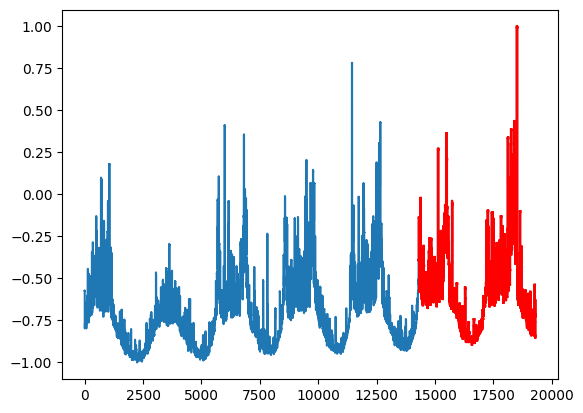

In [19]:

# plot forecasts
plot_forecasts(series, forecasts, n_test)